In [337]:
from sklearn.preprocessing import StandardScaler
import numpy as np 
from sklearn import neural_network
import matplotlib.pyplot as plt 
from sklearn import linear_model
import os

In [338]:
import numpy as np
from PIL import Image 
from skimage.io import imread
from skimage.transform import resize
def loadData():

    images = []
    labels = []

    limit = 100

    dir = "data/train/"
    count = 1
    for file in os.listdir(dir):
        img = imread(dir + file)
        img = resize(img, (15, 15))

        images.append(img.flatten())
        labels.append(0)

        if count >= limit: break
        count += 1

    dir = "data/train_sepia/"
    count = 1
    for file in os.listdir(dir):
        img = imread(dir + file)
        img = resize(img, (15, 15))

        images.append(img.flatten())
        labels.append(1)

        if count >= limit: break
        count += 1

    inputs = np.asarray(images)
    outputs = np.asarray(labels)

    noData = len(inputs)
    permutation = np.random.permutation(noData)
    inputs = inputs[permutation]
    outputs = outputs[permutation]

    return inputs, outputs

inputs, outputs = loadData()
outputNames = [0, 1]

In [339]:
def splitData(inputs, outputs):
    np.random.seed(5)
    indexes = [i for i in range(len(inputs))]
    trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace = False)
    testSample = [i for i in indexes  if not i in trainSample]

    trainInputs = [inputs[i] for i in trainSample]
    trainOutputs = [outputs[i] for i in trainSample]
    testInputs = [inputs[i] for i in testSample]
    testOutputs = [outputs[i] for i in testSample]
    
    return trainInputs, trainOutputs, testInputs, testOutputs

In [340]:
def plotConfusionMatrix(cm, classNames, title):
    from sklearn.metrics import confusion_matrix
    import itertools 

    plt.figure()
    plt.imshow(cm, interpolation = 'nearest', cmap = 'Blues')
    plt.title('Confusion Matrix ' + title)
    plt.colorbar()
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)

    text_format = 'd'
    thresh = cm.max() / 2.
    for row, column in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(column, row, format(cm[row, column], text_format),
                horizontalalignment = 'center',
                color = 'white' if cm[row, column] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.show()

def evalMultiClass(realLabels, computedLabels, labelNames):
    from sklearn.metrics import confusion_matrix

    confMatrix = confusion_matrix(realLabels, computedLabels)
    acc = sum([confMatrix[i][i] for i in range(len(labelNames))]) / len(realLabels)
    precision = {}
    recall = {}
    for i in range(len(labelNames)):
        precision[labelNames[i]] = confMatrix[i][i] / sum([confMatrix[j][i] for j in range(len(labelNames))])
        recall[labelNames[i]] = confMatrix[i][i] / sum([confMatrix[i][j] for j in range(len(labelNames))])
    return acc, precision, recall, confMatrix

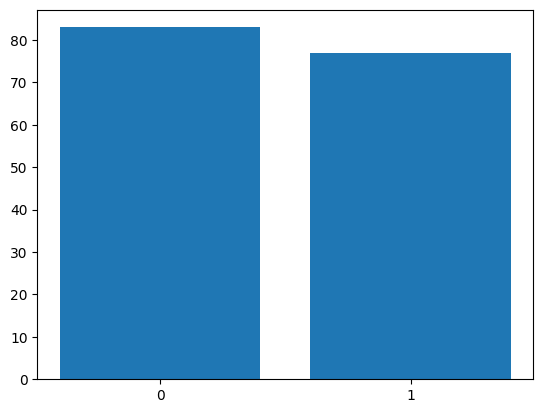

In [341]:
trainInputs, trainOutputs, testInputs, testOutputs = splitData(inputs, outputs)

bins = range(3)
plt.hist(trainOutputs, bins, rwidth = 0.8)
bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), outputNames)
plt.show()

trainInputs = np.array(trainInputs)
trainOutputs = np.array([[1, 0] if label == outputNames[0] else [0, 1] for label in trainOutputs])

In [342]:
import numpy as np

def softmax_derivative(x):
    s = softmax(x)
    return s * (1 - s)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.weights_input_hidden = np.random.randn(input_size, hidden_size)
        self.biases_input_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size)
        self.biases_hidden_output = np.zeros((1, output_size))

    def predict(self, X):
        self.hidden_output = softmax(np.dot(X, self.weights_input_hidden) + self.biases_input_hidden)
        self.output = softmax(np.dot(self.hidden_output, self.weights_hidden_output) + self.biases_hidden_output)
        return self.output

    def update(self, X, y, learning_rate):
        output_error = y - self.output
        output_delta = output_error * softmax_derivative(self.output)
        
        hidden_error = output_delta.dot(self.weights_hidden_output.T)
        hidden_delta = hidden_error * softmax_derivative(self.hidden_output)
        
        self.weights_hidden_output += self.hidden_output.T.dot(output_delta) * learning_rate
        self.biases_hidden_output += np.sum(output_delta, axis=0, keepdims=True) * learning_rate
        self.weights_input_hidden += X.T.dot(hidden_delta) * learning_rate
        self.biases_input_hidden += np.sum(hidden_delta, axis=0, keepdims=True) * learning_rate

    def train(self, X, y, epochs, learning_rate):
        for epoch in range(epochs):

            output = self.predict(X)
            
            self.update(X, y, learning_rate)
            
            if epoch % 10 == 0:
                loss = mse_loss(y, output)
                accuracy = self.accuracy(y, output)
                print(f'Epoch {epoch}: Loss = {loss}, Accuracy = {accuracy}')

    def accuracy(self, y_true, y_pred):
        y_true_cls = np.argmax(y_true, axis=1)
        y_pred_cls = np.argmax(y_pred, axis=1)
        correct_predictions = np.sum(y_true_cls == y_pred_cls)
        total_examples = y_true.shape[0]
        return correct_predictions / total_examples

Epoch 0: Loss = 0.38728552879274847, Accuracy = 0.4875
Epoch 10: Loss = 0.3577583558843041, Accuracy = 0.51875
Epoch 20: Loss = 0.33527111816607363, Accuracy = 0.51875
Epoch 30: Loss = 0.2992598909467694, Accuracy = 0.51875
Epoch 40: Loss = 0.13115441984321566, Accuracy = 0.79375
Epoch 50: Loss = 0.022858760423198263, Accuracy = 0.975
Epoch 60: Loss = 0.036582324628133725, Accuracy = 0.9625
Epoch 70: Loss = 0.05047924787551925, Accuracy = 0.94375
Epoch 80: Loss = 0.040657990233940525, Accuracy = 0.98125
Epoch 90: Loss = 0.022851261987546233, Accuracy = 0.98125
Epoch 100: Loss = 0.028535473963552736, Accuracy = 0.975
Epoch 110: Loss = 0.02777060917123044, Accuracy = 0.98125
Epoch 120: Loss = 0.0352615829883434, Accuracy = 0.9625
Epoch 130: Loss = 0.1684281702868281, Accuracy = 0.84375
Epoch 140: Loss = 0.0363454844901675, Accuracy = 0.9625


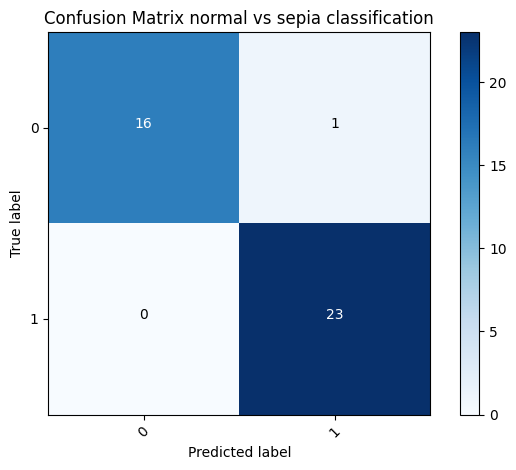

acc:  0.975
precision:  {0: 1.0, 1: 0.9583333333333334}
recall:  {0: 0.9411764705882353, 1: 1.0}


In [343]:
classifier = NeuralNetwork(trainInputs.shape[1], 15, 2)
classifier.classes_ = outputNames
classifier.train(trainInputs, trainOutputs, 150, .1)

predictedLabels = classifier.predict(testInputs)

predictedLabels = [0 if max(label) == label[0] else 1 for label in predictedLabels]

acc, prec, recall, cm = evalMultiClass(testOutputs, predictedLabels, outputNames)


plotConfusionMatrix(cm, outputNames, "normal vs sepia classification")
print('acc: ', acc)
print('precision: ', prec)
print('recall: ', recall)